# Table of Contents
--------------------
1. [Dataset Description](#1)
2. [Pipeline to insert dataset into MySQL Database](#2)
3. [Exploratory analysis](#3)

    3.1 [What crime has the highest occurrence all across Oakland?]
    3.2 [What crime has the highest occurrence in each location?]
        3.2.1 [What crime has the highest occurrence in International Blvd?]
    3.3 [What is the incident solving time for each incident?]

## 1

Data description: to be completed ...

## 2

### Import Packages

In [1]:
import pandas as pd
import os
import re
import numpy as np
import pymysql 
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
PATH = 'oakland-crime-statistics-2011-to-2016/'
FILE_2011 = PATH+'records-for-2011.csv'
FILE_2012 = PATH+'records-for-2012.csv'
FILE_2013 = PATH+'records-for-2013.csv'
FILE_2014 = PATH+'records-for-2014.csv'
FILE_2015 = PATH+'records-for-2015.csv'
FILE_2016 = PATH+'records-for-2016.csv'

### Data Preparing

#### clean address for data in 2012 and 2014

In [4]:
def convert_location_col(df, filename):
    reg_pattern = '\"address\":\"([A-Za-z0-9\s./#\(\),-]+)\"'
    address_lst = list(map(lambda x: re.findall(pattern=reg_pattern, string=df['Location 1'][x].replace('&amp;', ' ')), range(len(df))))
    address_lst_flattened = []
    for i in range(len(address_lst)):
        try:
            address_lst_flattened.append(address_lst[i][0])
        except Exception as e:
            address_lst_flattened.append(np.nan)
    df['Location'] = address_lst_flattened
    df = df.drop(columns=['Location 1'])
    df = pd.concat([df.iloc[:,:2], df.Location, df.iloc[:,2:-1]], axis=1)
    df.to_csv(filename, index=None)
    return df

In [113]:
df1 = convert_location_col(pd.read_csv(FILE_2012), FILE_2012)
df2 = convert_location_col(pd.read_csv(FILE_2014), FILE_2014)

#### convert time format to be MySQL compatible 

In [116]:
 def convert_time_sql_format():
    columns = ['Create Time', 'Closed Time']
    for y in range(1,7):
        filename = PATH + 'records-for-201{}.csv'.format(y)
        df = pd.read_csv(filename)
        for column in columns:
            tmp = []
            df = df.iloc[df[column].dropna().index, :].reset_index(drop=True)
            for i in df[column]:
                ymy = i.split('T')[0]
                hms = i.split('T')[1]
                splited_lst = ymy.split('-')
                year = splited_lst[0]
                month = splited_lst[1][1:] if splited_lst[1].startswith('0') else splited_lst[1]
                day = splited_lst[2][1:] if splited_lst[2].startswith('0')  else splited_lst[2]

                splited_lst = hms.split(':')
                hour = splited_lst[0][1:] if splited_lst[0].startswith('0') else splited_lst[0]
                minute = splited_lst[1][1:] if splited_lst[1].startswith('0') else splited_lst[1]
                second = splited_lst[2][1:] if splited_lst[2].startswith('0')  else splited_lst[2]

                tmp.append(datetime(int(year), int(month), int(day), int(hour), int(minute), int(second)))

            df[column] = pd.DataFrame(tmp)
        df['Days to Resolve'] = pd.DataFrame(list(map(lambda x: x.days, df[columns[1]] - df[columns[0]])))
        df['Area Id'] = df['Area Id'].fillna(value=0)
        df['Priority'] = df['Priority'].dropna(axis=0)
        df['Incident Type Id'] = df['Incident Type Id'].dropna(axis=0)
        df['Event Number'] = df['Event Number'].dropna(axis=0)
        df.to_csv(filename, index=None)

In [117]:
convert_time_sql_format()

### Load data into MySQL

In [20]:
class DataSqlLoader:
    def __init__(self, database):
        # connect to mysql local server
        self.database = database
        self.db = pymysql.Connect( 
            host = 'localhost',
            user = 'root',
            passwd = '',
            db=self.database)
        self.c = self.db.cursor()
    
    def creat_tables(self):
        for year in range(1, 7):
            try:
                self.c.execute('''
                        CREATE TABLE IF NOT EXISTS crimedata_201{}
                            (
                              `Agency`                   VARCHAR(5)   NULL,
                              `Create Time`              DATETIME     NULL,
                              Location                   VARCHAR(100) NULL,
                              `Area Id`                  VARCHAR(5)   NULL,
                              Beat                       VARCHAR(10)  NULL,
                              Priority                   Double       NULL,
                              `Incident Type Id`         VARCHAR(10)  NULL,
                              `Incident Type Description` TEXT         NULL,
                              `Event Number`             VARCHAR(30)  NOT NULL
                                PRIMARY KEY,
                              `Closed Time`              DATETIME     NULL,
                              `Days to Resolve`          INT          NULL,
                              CONSTRAINT crimedata_2011_EventNumber_uindex
                              UNIQUE (`Event Number`)
                            );
                        '''.format(year))
            except Exception as e:
                print(e)  
                
    def insert_into_tables(self, filename, tablename):
        query = '''
            LOAD DATA INFILE '{}'
                INTO TABLE {} fields terminated by ',' lines terminated by '\r\n'
            '''.format(filename, tablename)
        try:
            print(query)
            # self.c.execute(query)
        except Exception as e:
            print(e)
                
    def drop_table(self, tablename):
        try:
            self.c.execute("drop table {}".format(tablename))
        except Exception as e:
            print(e)
            
            
    def get_sample(self, table, limit=None):
        if limit == None:
            query = 'SELECT * FROM {};'.format(table)
        else:
            query = 'SELECT * FROM {} limit {};'.format(table, limit)
            pd.read_sql(sql=query, con=self.db)
        return pd.read_sql(sql=query, con=self.db)
    
    def sql_query(self, query):
        try:
            return pd.read_sql(sql=query, con=self.db)
        except Exception as e:
            print(e)
            
    def close(self):
        self.db.close()

In [21]:
dsl = DataSqlLoader('ds220')
# for year in range(1, 7):
#     tablename = 'crimedata_201{}'.format(year)
#     dsl.drop_table(tablename)
# dsl.creat_tables()
dsl.insert_into_tables(FILE_2011, 'crime_2011')
dsl.insert_into_tables(FILE_2012, 'crime_2012')
dsl.insert_into_tables(FILE_2013, 'crime_2013')
dsl.insert_into_tables(FILE_2014, 'crime_2014')
dsl.insert_into_tables(FILE_2015, 'crime_2015')
dsl.insert_into_tables(FILE_2016, 'crime_2016')


            LOAD DATA INFILE 'oakland-crime-statistics-2011-to-2016/records-for-2011.csv'
                INTO TABLE crime_2011 fields terminated by ',' lines terminated by '
'
            


## 3 Exploratory analysis

#### What crime has the highest occurrence all across Oakland?

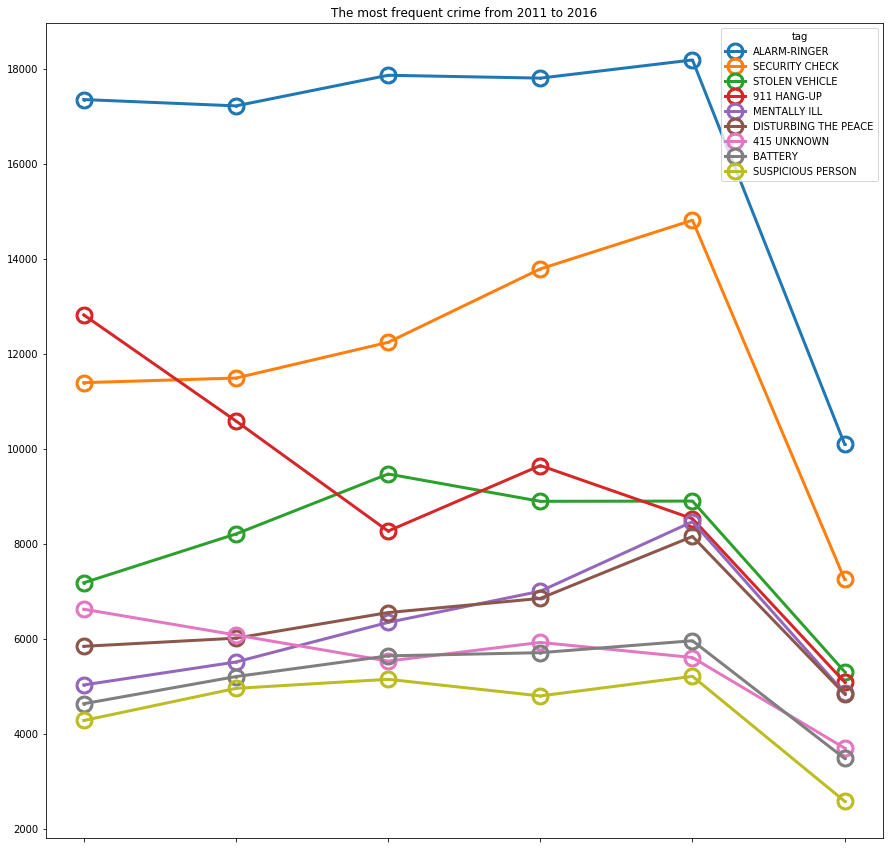

In [75]:
query = '''
    select t1.tag, t1.cnt, t2.cnt, t3.cnt, t4.cnt, t5.cnt, t6.cnt
        from
            (select `Incident Type Desciption` as tag, count(*) as cnt
             from crimedata_2011
                group by `Incident Type Desciption`
                order by cnt desc
                limit 10) as t1
            inner join
                      (select `Incident Type Desciption` as tag, count(*) as cnt
                       from crimedata_2012
                       group by `Incident Type Desciption`
                       order by cnt desc
                       limit 10) as t2
            inner join (select `Incident Type Desciption` as tag, count(*) as cnt
                        from crimedata_2013
                        group by `Incident Type Desciption`
                        order by cnt desc
                        limit 10) as t3
            inner join (select `Incident Type Desciption` as tag, count(*) as cnt
                        from crimedata_2014
                        group by `Incident Type Desciption`
                        order by cnt desc
                        limit 10) as t4
            inner join (select `Incident Type Desciption` as tag, count(*) as cnt
                        from crimedata_2015
                        group by `Incident Type Desciption`
                        order by cnt desc
                        limit 10) as t5
            inner join (select `Incident Type Desciption` as tag, count(*) as cnt
                        from crimedata_2016
                        group by `Incident Type Desciption`
                        order by cnt desc
                        limit 10) as t6
            on t1.tag=t2.tag
            and t2.tag=t3.tag
            and t3.tag=t4.tag
            and t4.tag=t5.tag
            and t5.tag=t6.tag;
    '''
highest_freq_crime_all_6_years = dsl.sql_query(query=query)
highest_freq_crime_all_6_years = highest_freq_crime_all_6_years.set_index('tag').transpose()
highest_freq_crime_all_6_years.plot(legend=True, figsize=(15,15), marker='.', lw=3, mew=15, title='The most frequent crime from 2011 to 2016')

#### What crime has the highest occurrence in each location? 

The top 3 location with highest crime rate in year 2011:
[['INTERNATIONAL BLVD' 'ALARM-RINGER' 3866]
 ['MACARTHUR BLVD' 'SECURITY CHECK' 3129]
 ['AV&INTERNATIONAL BLVD' '415 GUNSHOTS' 3067]]


The top 3 location with highest crime rate in year 2012:
[['INTERNATIONAL BLVD' 'ALARM-RINGER' 3866]
 ['MACARTHUR BLVD' 'SECURITY CHECK' 3129]
 ['AV&INTERNATIONAL BLVD' '415 GUNSHOTS' 3067]]


The top 3 location with highest crime rate in year 2013:
[['INTERNATIONAL BLVD' 'ALARM-RINGER' 3866]
 ['MACARTHUR BLVD' 'SECURITY CHECK' 3129]
 ['AV&INTERNATIONAL BLVD' '415 GUNSHOTS' 3067]]


The top 3 location with highest crime rate in year 2014:
[['INTERNATIONAL BLVD' 'ALARM-RINGER' 3866]
 ['MACARTHUR BLVD' 'SECURITY CHECK' 3129]
 ['AV&INTERNATIONAL BLVD' '415 GUNSHOTS' 3067]]


The top 3 location with highest crime rate in year 2015:
[['INTERNATIONAL BLVD' 'ALARM-RINGER' 3866]
 ['MACARTHUR BLVD' 'SECURITY CHECK' 3129]
 ['AV&INTERNATIONAL BLVD' '415 GUNSHOTS' 3067]]


The top 3 location with highest cri

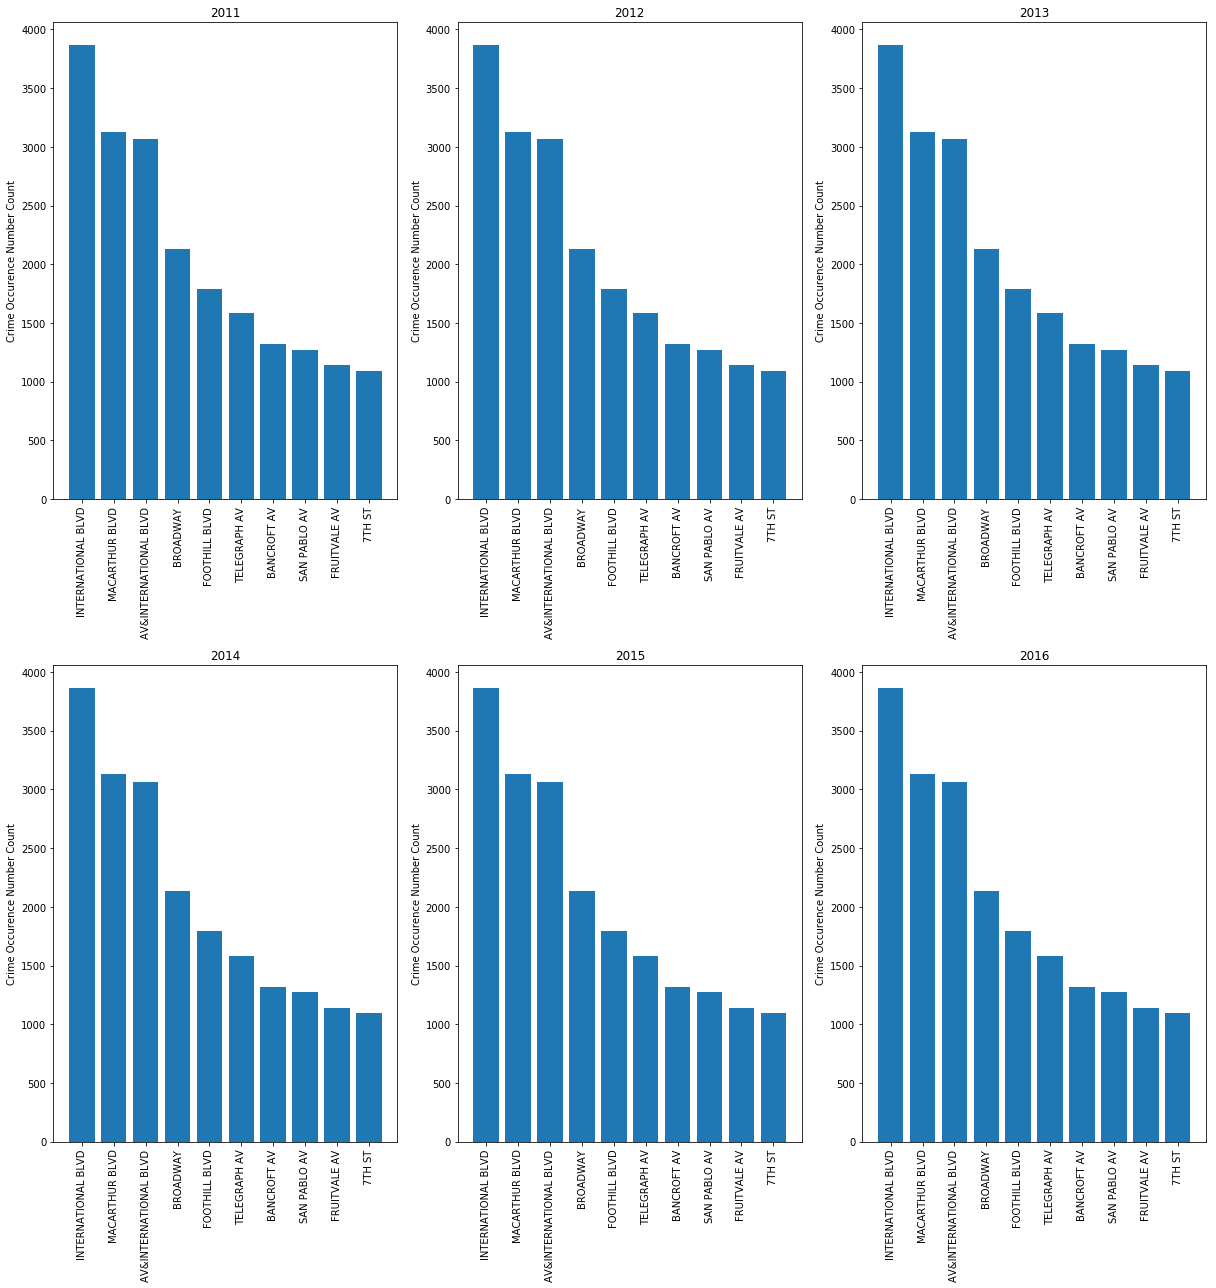

In [27]:
plt.figure(figsize=(17, 18))
for year in range(1, 7):
    location_cnt = dsl.sql_query("""select Location,
                                       `Incident Type Desciption`,
                                       count(*) cnt
                                from crimedata_2011
                                    group by Location
                                    order by cnt desc
                                  limit 10;
                                """.format(year))
    print('The top 3 location with highest crime rate in year 201{}:'.format(year))
    print(location_cnt.iloc[:3, :].values)
    print('\n')
    
    plt.subplot(2, 3, year)
    plt.bar(x=location_cnt.Location, height=location_cnt.cnt)
    plt.xticks(rotation=90)
    plt.ylabel('Crime Occurence Number Count')
    plt.title('201{}'.format(year))
    plt.tight_layout()
plt.show()

In [28]:
query = '''
    select t1.Location, 
            t1.cnt as count_2011, 
            t2.cnt as count_2012, 
            t3.cnt as count_2013, 
            t4.cnt as count_2014, 
            t5.cnt as count_2015, 
            t6.cnt as count_2016
    from
        (select Location,
                 count(*) cnt
          from crimedata_2011
          group by Location
          order by cnt desc limit 10) as t1
        inner join
                  (select Location,
                           count(*) cnt
                    from crimedata_2012
                    group by Location
                    order by cnt desc limit 10) as t2
        inner join (select Location,
                           count(*) cnt
                    from crimedata_2013
                    group by Location
                    order by cnt desc limit 10) as t3
        inner join (select Location,
                           count(*) cnt
                    from crimedata_2014
                    group by Location
                    order by cnt desc limit 10) as t4
        inner join (select Location,
                           count(*) cnt
                    from crimedata_2015
                    group by Location
                    order by cnt desc limit 10) as t5
        inner join (select Location,
                           count(*) cnt
                    from crimedata_2016
                    group by Location
                    order by cnt desc limit 10) as t6
        on t1.Location=t2.Location
        and t2.Location=t3.Location
        and t3.Location=t4.Location
        and t4.Location=t5.Location
        and t5.Location=t6.Location;
'''
highest_freq_crime_location_all_6_years = dsl.sql_query(query=query)

In [29]:
highest_freq_crime_location_all_6_years = highest_freq_crime_location_all_6_years.set_index('Location').transpose()

In [30]:
print(highest_freq_crime_location_all_6_years.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
Location &  INTERNATIONAL BLVD &  MACARTHUR BLVD &  BROADWAY &  FOOTHILL BLVD &  TELEGRAPH AV &  7TH ST \\
\midrule
count\_2011 &                3866 &            3129 &      2132 &           1791 &          1584 &    1093 \\
count\_2012 &                3658 &            3335 &      2167 &           1649 &          1623 &    1183 \\
count\_2013 &                3647 &            3002 &      2036 &           1650 &          1558 &    1246 \\
count\_2014 &                3713 &            2812 &      1996 &           1774 &          1573 &    1285 \\
count\_2015 &                3695 &            3105 &      2407 &           1753 &          1507 &    1569 \\
count\_2016 &                2156 &            1813 &      1476 &           1052 &           875 &    1224 \\
\bottomrule
\end{tabular}



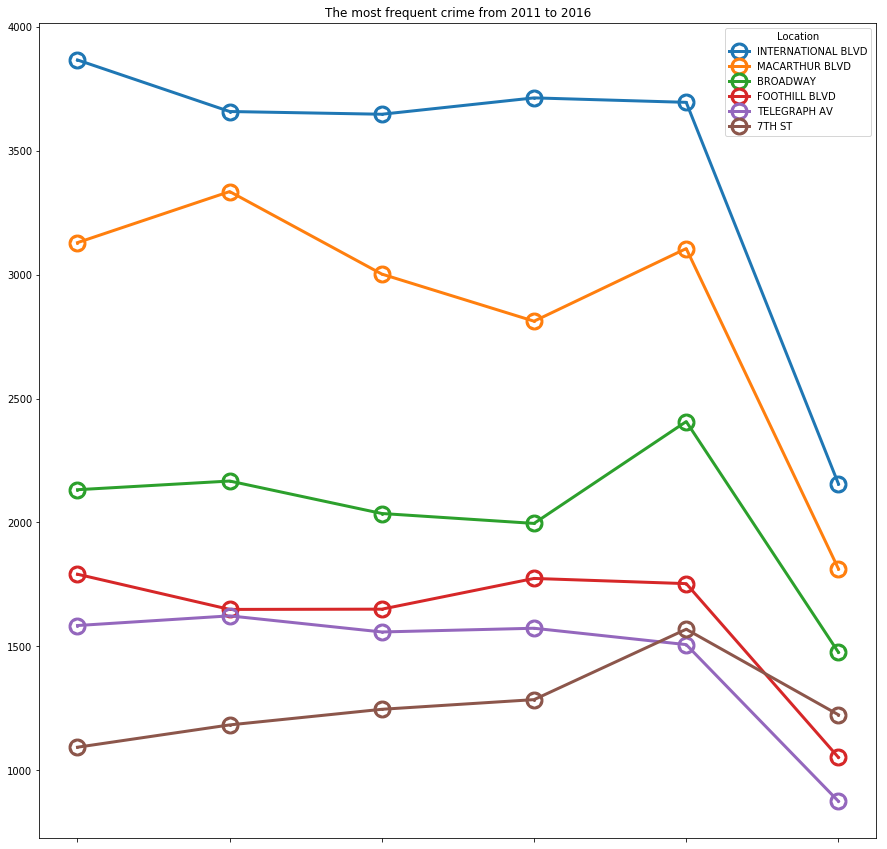

In [39]:
highest_freq_crime_location_all_6_years.plot(legend=True, figsize=(15,15), marker='.', lw=3, mew=15, title='The location with highest crime rate from 2011 to 2016')

#### What crime has the highest occurrence in __International Blvd__?

In [31]:
query = '''
    select t1.tag, t1.cnt, t2.cnt, t3.cnt, t4.cnt, t5.cnt, t6.cnt
    from
        (select `Incident Type Desciption` as tag, count(*) as cnt
         from crimedata_2011
            where Location='INTERNATIONAL BLVD'
            group by `Incident Type Desciption`
            order by cnt desc
            limit 10) as t1
        inner join
                  (select `Incident Type Desciption` as tag, count(*) as cnt
                   from crimedata_2012
                   where Location='INTERNATIONAL BLVD'
                   group by `Incident Type Desciption`
                   order by cnt desc
                   limit 10) as t2
        inner join (select `Incident Type Desciption` as tag, count(*) as cnt
                    from crimedata_2013
                    where Location='INTERNATIONAL BLVD'
                    group by `Incident Type Desciption`
                    order by cnt desc
                    limit 10) as t3
        inner join (select `Incident Type Desciption` as tag, count(*) as cnt
                    from crimedata_2014
                    where Location='INTERNATIONAL BLVD'
                    group by `Incident Type Desciption`
                    order by cnt desc
                    limit 10) as t4
        inner join (select `Incident Type Desciption` as tag, count(*) as cnt
                    from crimedata_2015
                    where Location='INTERNATIONAL BLVD'
                    group by `Incident Type Desciption`
                    order by cnt desc
                    limit 10) as t5
        inner join (select `Incident Type Desciption` as tag, count(*) as cnt
                    from crimedata_2016
                    where Location='INTERNATIONAL BLVD'
                    group by `Incident Type Desciption`
                    order by cnt desc
                    limit 10) as t6
        on t1.tag=t2.tag
        and t2.tag=t3.tag
        and t3.tag=t4.tag
        and t4.tag=t5.tag
        and t5.tag=t6.tag;
'''
highest_freq_crime_internationalblvd_all_6_years = dsl.sql_query(query=query)

In [32]:
highest_freq_crime_internationalblvd_all_6_years = pd.concat([highest_freq_crime_internationalblvd_all_6_years.tag, 
                                                              highest_freq_crime_internationalblvd_all_6_years.sum(axis=1)], axis=1)
highest_freq_crime_internationalblvd_all_6_years.columns = ['crime type', 'occurrence']

In [34]:
print(highest_freq_crime_internationalblvd_all_6_years.to_latex())

\begin{tabular}{llr}
\toprule
{} &            crime type &  occurrence \\
\midrule
0 &          ALARM-RINGER &        1979 \\
1 &           911 HANG-UP &        1646 \\
2 &  DISTURBING THE PEACE &        1009 \\
3 &          MENTALLY ILL &         911 \\
4 &           415 UNKNOWN &         984 \\
5 &               BATTERY &         723 \\
6 &        SECURITY CHECK &        1456 \\
7 &        STOLEN VEHICLE &         725 \\
\bottomrule
\end{tabular}



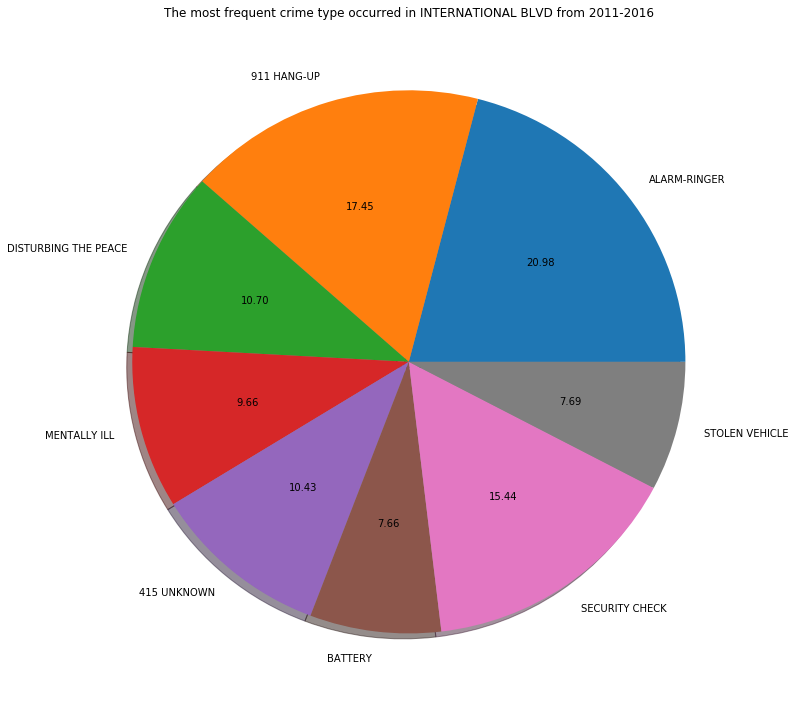

In [64]:
# high frequency crime type in the location with the highest crime rate
plt.figure(figsize=(10, 10))
plt.pie(highest_freq_crime_internationalblvd_all_6_years.occurrence,
        labels=highest_freq_crime_internationalblvd_all_6_years['crime type'],
        autopct = '%.2f',
        shadow=True)
plt.title('The most frequent crime type occurred in INTERNATIONAL BLVD from 2011-2016')
plt.tight_layout()
plt.show()

#### What is the incident solving time for each incident?

The top 3 crime that took the longest time to resolve in year 2011:
[['262' 'SPOUSAL RAPE' '262 : SPOUSAL RAPE' 3.0]
 ['187' 'MURDER' '187 : MURDER' 1.875]
 ['666' 'PETTY THEFT W/PRIORS' '666 : PETTY THEFT W/PRIORS' 1.0]]


The top 3 crime that took the longest time to resolve in year 2012:
[['262' 'SPOUSAL RAPE' '262 : SPOUSAL RAPE' 3.0]
 ['187' 'MURDER' '187 : MURDER' 1.875]
 ['666' 'PETTY THEFT W/PRIORS' '666 : PETTY THEFT W/PRIORS' 1.0]]


The top 3 crime that took the longest time to resolve in year 2013:
[['20001' 'HIT & RUN RESULTING' '20001 : HIT & RUN RESULTING' 0.7746]
 ['187' 'MURDER' '187 : MURDER' 0.7143]
 ['484G' 'FRAUDULENT USE OF AC' '484G : FRAUDULENT USE OF AC' 0.4]]


The top 3 crime that took the longest time to resolve in year 2014:
[['187' 'MURDER' '187 : MURDER' 32.5758]
 ['207' 'KIDNAPPING' '207 : KIDNAPPING' 4.9483]
 ['148' 'OBSTRUCTING JUSTICE-' '148 : OBSTRUCTING JUSTICE-' 2.375]]


The top 3 crime that took the longest time to resolve in year 2015:
[['187' '

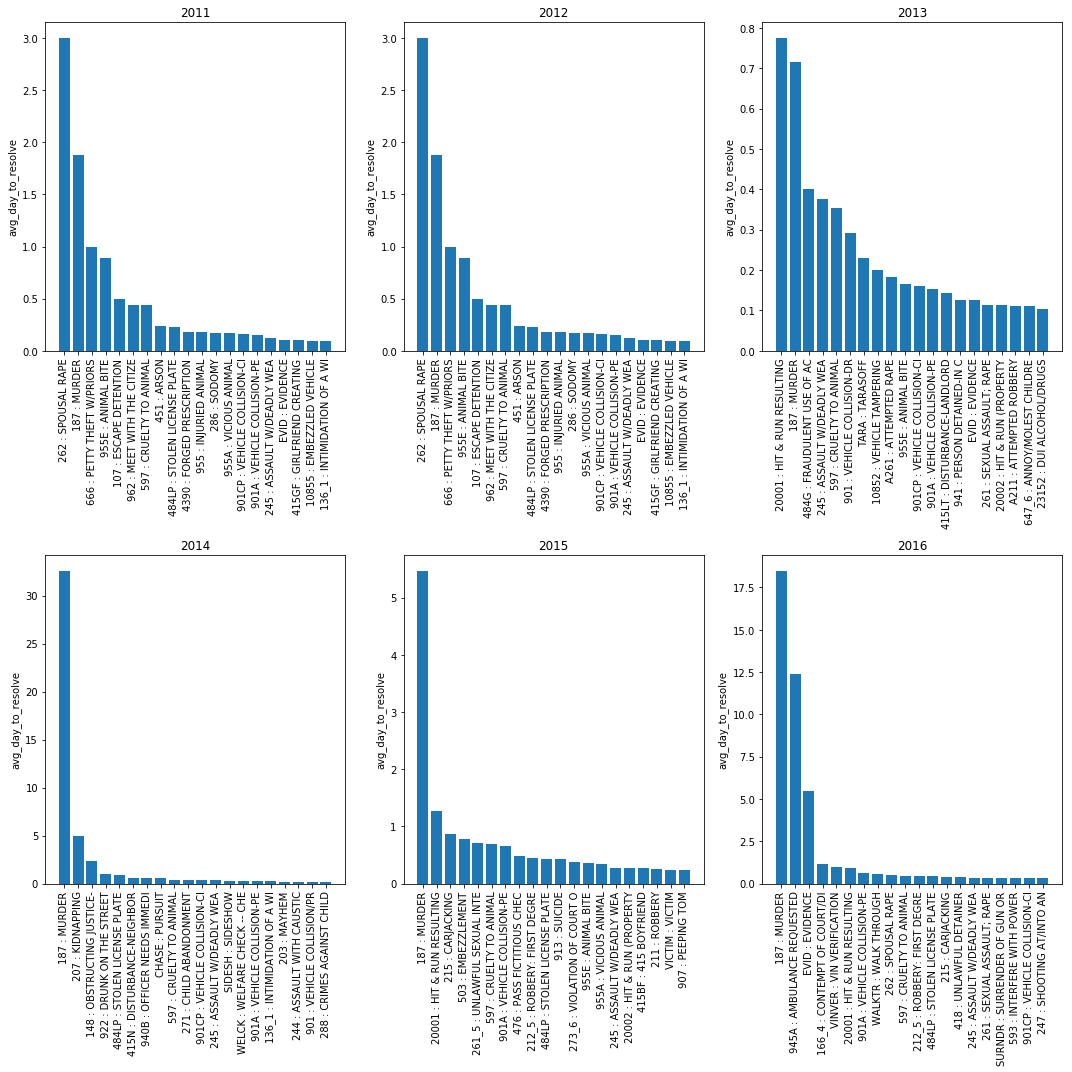

In [15]:
plt.figure(figsize=(15,15))
for year in range(1, 7):
    query = '''
        SELECT `Incident Type Id`,
               `Incident Type Desciption`,
               concat(`Incident Type Id`, ' : ', `Incident Type Desciption`) as tag,
                avg(`Days to Resolve`) as avg_day_to_resolve
        FROM crimedata_201{}
            GROUP BY `Incident Type Id`
            order by avg_day_to_resolve desc
          limit 20;
    '''.format(year)
    df_tmp = dsl.sql_query(query)
    print('The top 3 crime that took the longest time to resolve in year 201{}:'.format(year))
    print(df_tmp.iloc[:3, :].values)
    print('\n')
    plt.subplot(2, 3, year)
    plt.bar(x=df_tmp['tag'].astype('str').values, height=df_tmp['avg_day_to_resolve'].values)
    plt.xticks(rotation=90)
    #plt.xlabel(xlabel='Incident Type Id')
    plt.ylabel('avg_day_to_resolve')
    plt.title('201{}'.format(year))
    plt.tight_layout()
plt.show()

In [38]:
query = '''
    select t1.`Incident Type Desciption`, 
       t1.avg_day_to_resolve, 
       t2.avg_day_to_resolve, 
       t3.avg_day_to_resolve, 
       t4.avg_day_to_resolve, 
       t5.avg_day_to_resolve, 
       t6.avg_day_to_resolve from
        (SELECT `Incident Type Id`,
                `Incident Type Desciption`,
                 avg(`Days to Resolve`) as avg_day_to_resolve
          FROM crimedata_2011
            GROUP BY `Incident Type Id`
            order by avg_day_to_resolve desc
            limit 50) as t1
        inner join
                  (SELECT `Incident Type Id`,
                          `Incident Type Desciption`,
                          avg(`Days to Resolve`) as avg_day_to_resolve
                   FROM crimedata_2012
                   GROUP BY `Incident Type Id`
                   order by avg_day_to_resolve desc
                   limit 50) as t2
        inner join (SELECT `Incident Type Id`,
                           `Incident Type Desciption`,
                           avg(`Days to Resolve`) as avg_day_to_resolve
                    FROM crimedata_2013
                    GROUP BY `Incident Type Id`
                    order by avg_day_to_resolve desc
                    limit 50) as t3
        inner join (SELECT `Incident Type Id`,
                           `Incident Type Desciption`,
                           avg(`Days to Resolve`) as avg_day_to_resolve
                    FROM crimedata_2014
                    GROUP BY `Incident Type Id`
                    order by avg_day_to_resolve desc
                    limit 50) as t4
        inner join (SELECT `Incident Type Id`,
                           `Incident Type Desciption`,
                           avg(`Days to Resolve`) as avg_day_to_resolve
                    FROM crimedata_2015
                    GROUP BY `Incident Type Id`
                    order by avg_day_to_resolve desc
                    limit 50) as t5
        inner join (SELECT `Incident Type Id`,
                           `Incident Type Desciption`,
                           avg(`Days to Resolve`) as avg_day_to_resolve
                    FROM crimedata_2016
                    GROUP BY `Incident Type Id`
                    order by avg_day_to_resolve desc
                    limit 50) as t6
        on t1.`Incident Type Id`=t2.`Incident Type Id`
        and t2.`Incident Type Id`=t3.`Incident Type Id`
        and t3.`Incident Type Id`=t4.`Incident Type Id`
        and t4.`Incident Type Id`=t5.`Incident Type Id`
        and t5.`Incident Type Id`=t6.`Incident Type Id`;
'''

In [39]:
avg_day_resolve_df = dsl.sql_query(query=query)

In [40]:
avg_day_resolve_df_top_5 = avg_day_resolve_df.iloc[:5, :]
avg_day_resolve_df_top_5 = avg_day_resolve_df_top_5.set_index('Incident Type Desciption').transpose()
avg_day_resolve_df_top_5

Incident Type Desciption,MURDER,ANIMAL BITE,CRUELTY TO ANIMAL,VICIOUS ANIMAL,VEHICLE COLLISION-PE
avg_day_to_resolve,1.8750,0.8884,0.4347,0.1660,0.1542
avg_day_to_resolve,0.7143,0.1660,0.3531,0.0738,0.1524
avg_day_to_resolve,32.5758,0.1453,0.4140,0.1200,0.2821
avg_day_to_resolve,5.4688,0.3646,0.6883,0.3364,0.6486
avg_day_to_resolve,18.4839,0.1588,0.4433,0.1555,0.6310
avg_day_to_resolve,5.4118,0.2806,0.5074,0.1727,0.1474


In [41]:
print(avg_day_resolve_df_top_5.to_latex())

\begin{tabular}{lrrrrr}
\toprule
Incident Type Desciption &   MURDER &  ANIMAL BITE &  CRUELTY TO ANIMAL &  VICIOUS ANIMAL &  VEHICLE COLLISION-PE \\
\midrule
avg\_day\_to\_resolve &   1.8750 &       0.8884 &             0.4347 &          0.1660 &                0.1542 \\
avg\_day\_to\_resolve &   0.7143 &       0.1660 &             0.3531 &          0.0738 &                0.1524 \\
avg\_day\_to\_resolve &  32.5758 &       0.1453 &             0.4140 &          0.1200 &                0.2821 \\
avg\_day\_to\_resolve &   5.4688 &       0.3646 &             0.6883 &          0.3364 &                0.6486 \\
avg\_day\_to\_resolve &  18.4839 &       0.1588 &             0.4433 &          0.1555 &                0.6310 \\
avg\_day\_to\_resolve &   5.4118 &       0.2806 &             0.5074 &          0.1727 &                0.1474 \\
\bottomrule
\end{tabular}



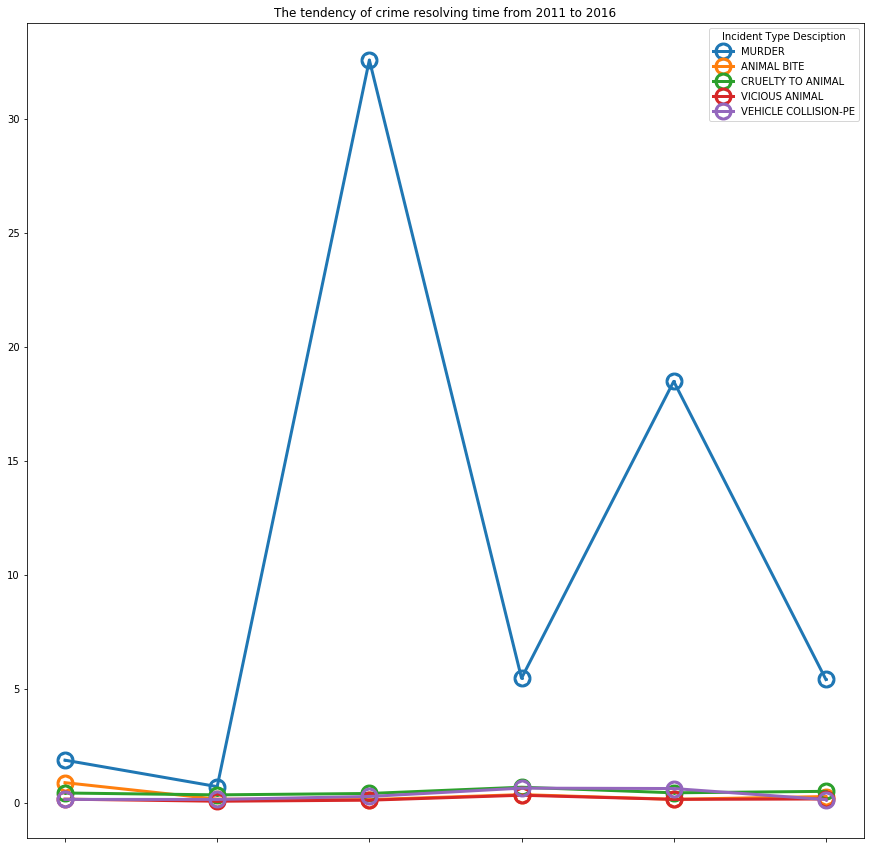

In [71]:
avg_day_resolve_df_top_5.plot(legend=True, figsize=(15,15), marker='.', lw=3, mew=15, title='The tendency of crime resolving time from 2011 to 2016')